In [2]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

In [29]:
%load_ext watermark

In [30]:
%watermark -a 'Amr Mashlah' -d -u -v -p nltk,lxml,io,bs4,requests,gender_guesser,collections,re,itertools,logging,pickle,pandas

Amr Mashlah 
last updated: 2019-01-04 

CPython 3.5.6
IPython 6.5.0

nltk 3.3
lxml unknown
io unknown
bs4 4.6.3
requests 2.19.1
gender_guesser unknown
collections unknown
re 2.2.1
itertools unknown
logging 0.5.1.2
pickle unknown
pandas 0.23.4


In [3]:
with open('gender_dict.pk', 'rb') as f:
    gender_dict = pickle.load(f)

In [4]:
with open('results.pk', 'rb') as f:
    movies_result = pickle.load(f)

In [5]:
def number_of_scenes_w_gender(chr_seq, gender):
    gender_in_scene = []
    
    for characters in chr_seq:
        gender_in_scene.append(gender in [gender_dict.get(x) for x in characters])
         
    return sum(gender_in_scene)

def number_of_men(chr_seq):
    return sum([1 for characters in chr_seq for x in characters if gender_dict.get(x) == 'male'])

def number_of_women(chr_seq):
    return sum([1 for characters in chr_seq for x in characters if gender_dict.get(x) == 'female'])

def ratio(row, first, second):
    try:
        return row[first] / (row[first] + row[second])
    except:
        return 0

In [6]:
df = pd.DataFrame(movies_result).T
df.loc[:,'number_of_scenes'] = df.characters_seq.apply(len).copy()
df.loc[:,'n_scenes_w_men'] = df.characters_seq.apply(lambda x:number_of_scenes_w_gender(x,'male')).copy()
df.loc[:,'n_scenes_w_women'] = df.characters_seq.apply(lambda x: number_of_scenes_w_gender(x, 'female')).copy()
df.loc[:,'number_of_men'] = df.characters_seq.apply(number_of_men).copy()
df.loc[:,'number_of_women'] = df.characters_seq.apply(number_of_women).copy()
df.loc[:,'women_ratio_in_scenes'] = df.apply(lambda x: ratio(x, 'n_scenes_w_women','n_scenes_w_men' ) , axis=1).copy()
df.loc[:,'women_ratio'] = df.apply(lambda x: ratio(x, 'number_of_women','number_of_men' ) , axis=1).copy()

In [7]:
df.dropna(subset=['release_date'], inplace=True)

In [8]:
df.drop(['characters_seq'], axis=1, inplace=True)

Removing movies with no release date.

That leaves us with around 845 movies

Text(0.5, 1.0, 'Histogram of number of scenes in all movies')

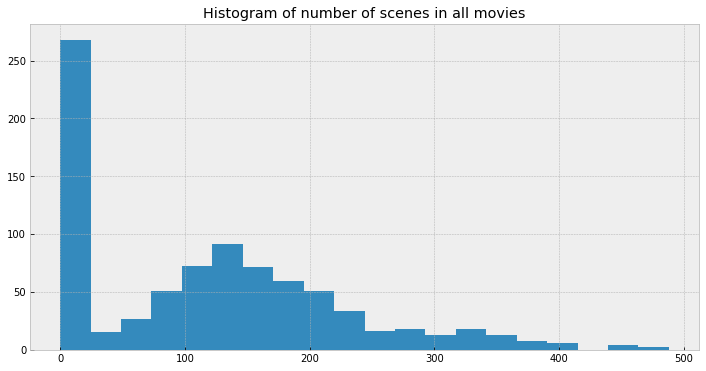

In [9]:
df.number_of_scenes.hist(bins=20, figsize=(12,6))
plt.title('Histogram of number of scenes in all movies')

### Sanity check: removing movies that were not parsed properly:

Removing movies with **`number_of_scenes`** less than `30` 
OR
**`women_ratio`** ==0

In [10]:
df = df[(df.women_ratio != 0.0) & (df.number_of_scenes > 30) & (df.number_of_scenes < 500)]

In [11]:
print('Number of movies that passes this criteria: ')
df.shape

Number of movies that passes this criteria: 


(553, 11)

#### Visualising sample of calcuated ratios

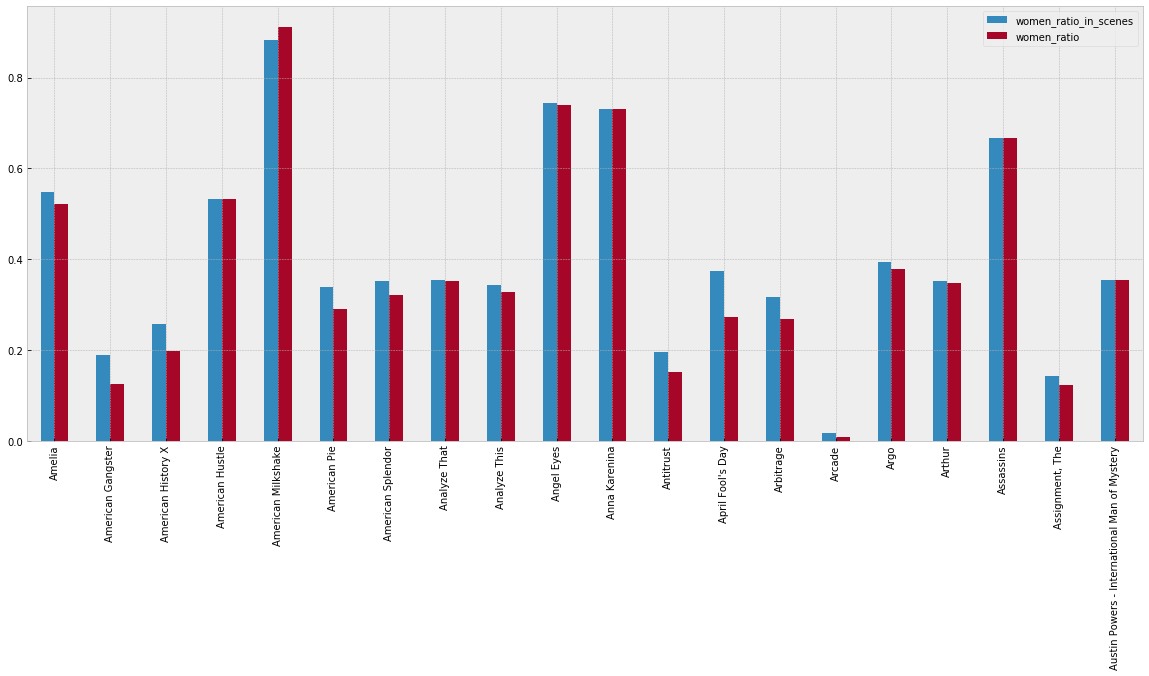

In [12]:
df[['women_ratio_in_scenes', 'women_ratio']][30:50].plot(kind='bar',figsize=(20,8))

#### Visualising women representation in movies as a ratio of women to men characters

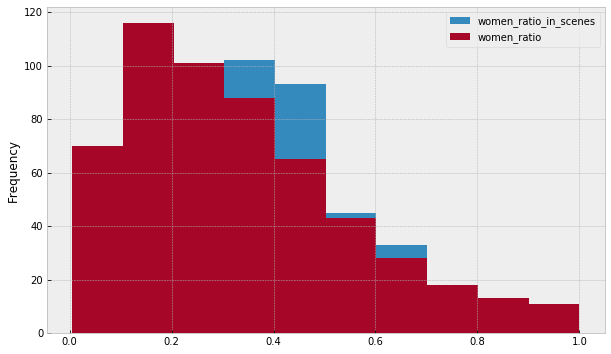

In [13]:
df[['women_ratio_in_scenes','women_ratio']].plot.hist(figsize=(10,6))

### How many movies pass Bechdel test

Full refers to Bechdal test including analysing the dialog between caracters to exlude scenes with men mentioned in the dialog.

In [14]:
pd.DataFrame(df.basic.value_counts() / df.shape[0]).join(df.full.value_counts() / df.shape[0])

,basic,full
False,0.567812,0.618445
True,0.432188,0.381555


Text(0, 0.5, 'Number of movies')

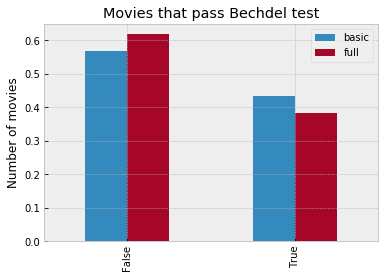

In [15]:
pd.DataFrame(df.basic.value_counts() / df.shape[0]).join(df.full.value_counts() / df.shape[0]).plot(kind='bar')
plt.title('Movies that pass Bechdel test')
plt.ylabel("Number of movies")

#### It would be interesting to investigate how these ratios are change across time.

In [16]:
df.rename(columns={'full':'Full_Bechdal_Test'}, inplace=True)

In [25]:
df.loc[:,'release_decade'] = df.release_date.apply(lambda x:(x.year//10)*10).copy()

Text(0, 0.5, 'Ratio of Passed to Failed Movies')

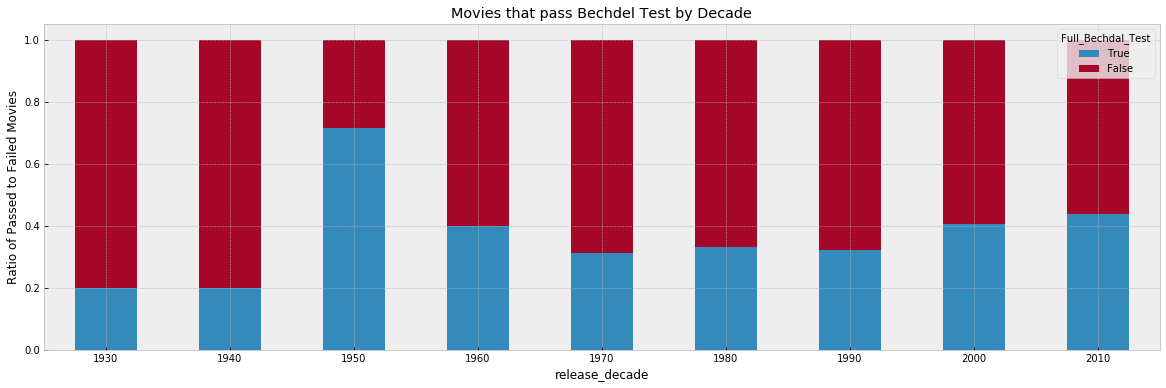

In [31]:
(df.groupby('release_decade').Full_Bechdal_Test.value_counts().sort_index()/df.groupby('release_decade').size().sort_index())\
                        .unstack('Full_Bechdal_Test').loc[:,::-1].plot(kind='bar', stacked=True, figsize=(20,6), rot=0)
plt.title('Movies that pass Bechdel Test by Decade')
plt.ylabel("Ratio of Passed to Failed Movies")

We can observe a slight improvement over time, but not as one would expect! 